In [15]:
import pandas as pd

# Formatting the data into two columns
data_willingham = [(80.922,779.34),
    (80.442, 767.94), (79.898, 750.23), (79.413, 744.04), (78.891, 732.07),
    (74.028, 627.93), (67.135, 500.69), (60.784, 402.42), (54.832, 324.93),
    (49.066, 261.75), (44.284, 217.16), (39.078, 175.89), (35.191, 149.43),
    (31.004, 124.67), (26.886, 103.64), (23.270, 87.75), (20.694, 77.28),
    (17.720, 67.22), (14.548, 57.41)
]

# Creating a DataFrame
data_willingham = pd.DataFrame(data_willingham, columns=['Temperature (C)', 'VP (mmHg)'])
#t to kelving and VP to pascal
data_willingham['Temperature (K)'] = data_willingham['Temperature (C)'] + 273.15
data_willingham['VP (Pa)'] = data_willingham['VP (mmHg)'] * 133.322
data_willingham['Source'] = 'Willingham (1945)'

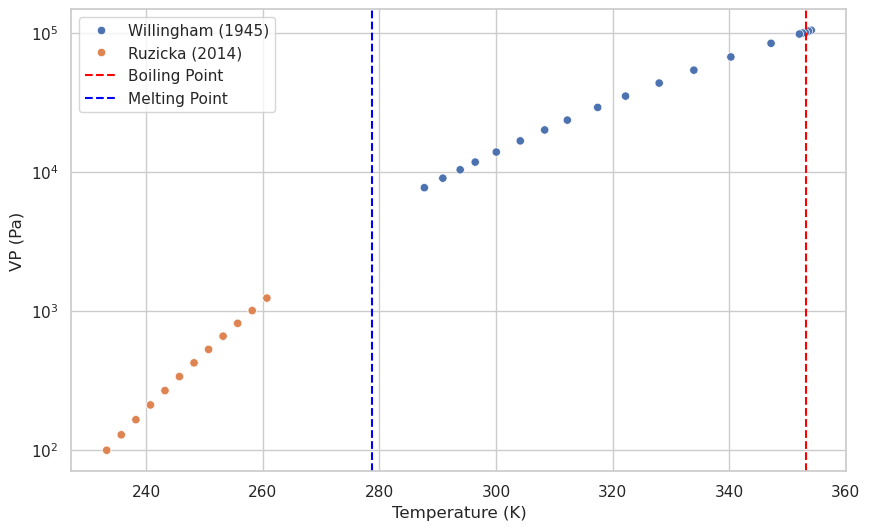

In [18]:
data_ruzicka = [(233.20, 98.91),
    (233.20, 99.02), (233.20, 98.85), (235.70, 127.71), (235.70, 127.71),
    (235.70, 127.70), (238.21, 164.09), (238.21, 164.10), (238.21, 164.09),
    (240.70, 209.51), (240.70, 209.32), (240.70, 209.40), (243.20, 265.53),
    (243.20, 265.57), (243.20, 265.57), (245.68, 335.09), (245.68, 335.20),
    (245.68, 335.01), (248.18, 420.57), (248.18, 420.54), (248.18, 420.55),
    (250.68, 525.26), (250.68, 525.70), (250.68, 525.34), (253.17, 653.26),
    (253.17, 653.22), (253.17, 654.35), (255.67, 809.50), (255.67, 809.56),
    (255.67, 809.24), (258.16, 999.68), (258.16, 999.52), (258.16, 999.38),
    (260.68, 1230.75), (260.68, 1229.31), (260.68, 1229.41)
]

data_ruzicka = pd.DataFrame(data_ruzicka, columns=['Temperature (K)', 'VP (Pa)'])
data_ruzicka['Source'] = 'Ruzicka (2014)'
#plot both, with BP and MP, color by source
data = pd.concat([data_willingham, data_ruzicka])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (K)', y='VP (Pa)', hue='Source', data=data)
#v lines at 80.1C and 5.5
bp = 80.1 + 273.15
mp = 5.5 + 273.15
plt.axvline(bp, color='red', linestyle='--', label='Boiling Point')
plt.axvline(mp, color='blue', linestyle='--', label='Melting Point')
plt.legend()
plt.yscale('log')
plt.show()



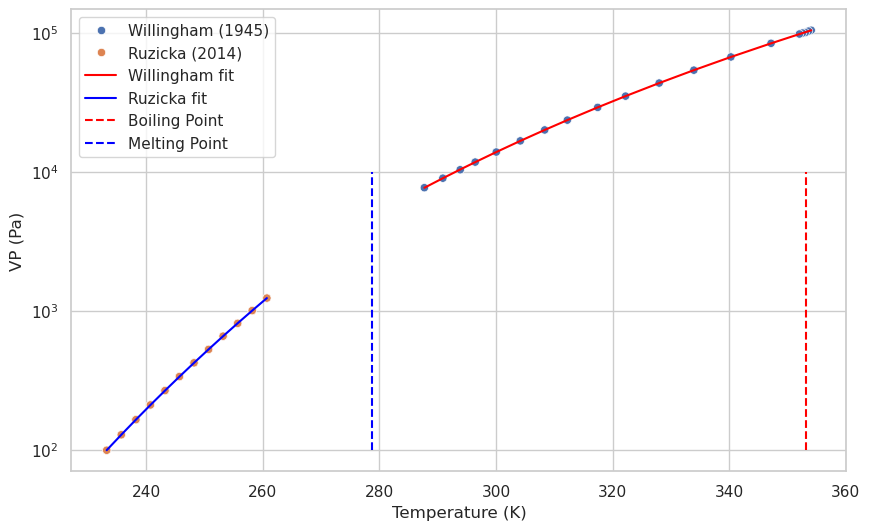

In [43]:
import numpy as np
from scipy.optimize import curve_fit

# Function to represent the Antoine equation
def antoine_equation(T, A, B, C):
    return A - B / (C + T)

# Function to fit Antoine equation coefficients
def fit_antoine_coefficients(temperatures_kelvin, vapor_pressures_pa, p0=(8, 1500, 200)):
    # Convert temperatures to Celsius
    temperatures_celsius = temperatures_kelvin - 273.15
    # Convert vapor pressures to log10 scale
    log_vapor_pressures = np.log10(vapor_pressures_pa)
    
    # Increase maxfev and provide initial parameter guesses
    popt, _ = curve_fit(
        antoine_equation, 
        temperatures_celsius, 
        log_vapor_pressures, 
        p0=p0, 
        maxfev=5000  # Increase the number of function evaluations
    )
    
    # Return the fitted coefficients A, B, C
    return popt

# Function to calculate vapor pressure for a temperature range using Antoine coefficients
def calculate_vapor_pressure_range(temperature_range_kelvin, A, B, C):
    temperatures_celsius = temperature_range_kelvin - 273.15
    log_vapor_pressures = antoine_equation(temperatures_celsius, A, B, C)
    vapor_pressures = 10 ** log_vapor_pressures  # Convert back from log scale
    return vapor_pressures

# Fit the Antoine equation to the Willingham data
temps_willingham = data_willingham['Temperature (K)'].values
vps = data_willingham['VP (Pa)'].values
A_willingham, B_willingham, C_willingham = fit_antoine_coefficients(temps_willingham, vps)
vps_willingham = calculate_vapor_pressure_range(temps_willingham, A_willingham, B_willingham, C_willingham)

# Fit the Antoine equation to the Ruzicka data
temps = data_ruzicka['Temperature (K)'].values
vps = data_ruzicka['VP (Pa)'].values
A_ruzicka, B_ruzicka, C_ruzicka = fit_antoine_coefficients(temps, vps)
vps_ruzicka = calculate_vapor_pressure_range(temps, A_ruzicka, B_ruzicka, C_ruzicka)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (K)', y='VP (Pa)', hue='Source', data=data)
plt.plot(temps_willingham, vps_willingham, label='Willingham fit', color='red')
plt.plot(temps, vps_ruzicka, label='Ruzicka fit', color='blue')
plt.vlines(bp, 1e2, 1e4, color='red', linestyle='--', label='Boiling Point')
plt.vlines(mp, 1e2, 1e4, color='blue', linestyle='--', label='Melting Point')
plt.legend()
plt.yscale('log')
plt.show()




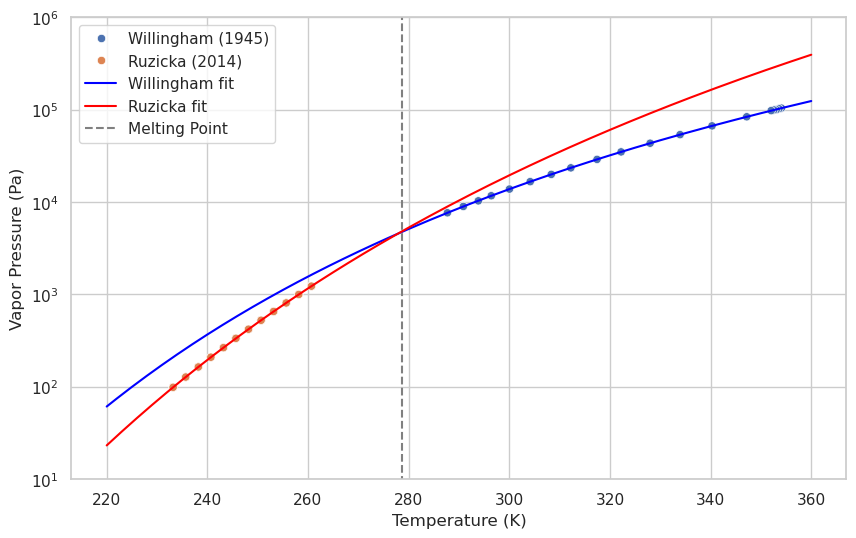

In [59]:
#now get the fitted temperatures for full range (220-360)
temps_full = np.arange(220, 361)
vps_full_willingham = calculate_vapor_pressure_range(temps_full, A_willingham, B_willingham, C_willingham)
vps_full_ruzicka = calculate_vapor_pressure_range(temps_full, A_ruzicka, B_ruzicka, C_ruzicka)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (K)', y='VP (Pa)', hue='Source', data=data)
plt.plot(temps_full, vps_full_willingham, label='Willingham fit', color='blue')
plt.plot(temps_full, vps_full_ruzicka, label='Ruzicka fit', color='red')
# plt.vlines(bp,0,10e6, color='black', linestyle='--', label='Boiling Point')
plt.vlines(mp, 0,10e6, color='grey', linestyle='--', label='Melting Point')
plt.ylim(1e1, 1e6)  
plt.ylabel('Vapor Pressure (Pa)')
plt.legend()
plt.yscale('log')
plt.savefig('vapor_pressure_benzene.png')
plt.show()


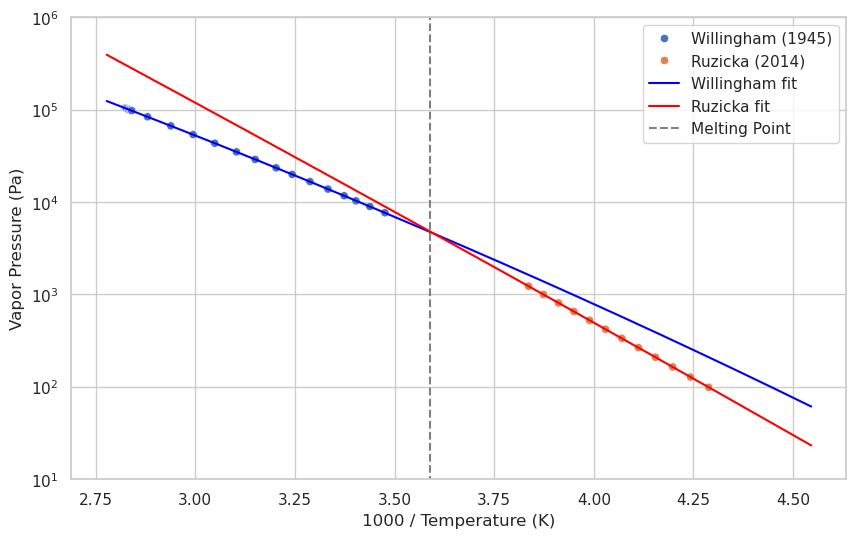

In [63]:
#now get the fitted temperatures for full range (220-360)
temps_full = np.arange(220, 361)
vps_full_willingham = calculate_vapor_pressure_range(temps_full, A_willingham, B_willingham, C_willingham)
vps_full_ruzicka = calculate_vapor_pressure_range(temps_full, A_ruzicka, B_ruzicka, C_ruzicka)
inverse_temps = 1000 / temps_full
data['1000 / Temperature (K)'] = 1000 / data['Temperature (K)']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='1000 / Temperature (K)', y='VP (Pa)', hue='Source', data=data)
plt.plot(inverse_temps, vps_full_willingham, label='Willingham fit', color='blue')
plt.plot(inverse_temps, vps_full_ruzicka, label='Ruzicka fit', color='red')
# plt.vlines(bp,0,10e6, color='black', linestyle='--', label='Boiling Point')
melting_point_inverse = 1000 / mp
plt.vlines(melting_point_inverse, 0,10e6, color='grey', linestyle='--', label='Melting Point')
plt.ylim(1e1, 1e6)  
plt.ylabel('Vapor Pressure (Pa)')
plt.legend()
plt.yscale('log')
plt.xlabel('1000 / Temperature (K)')
plt.savefig('vapor_pressure_benzene_inverse.png')
plt.show()


In [64]:
#save all the data
data.to_csv('benzene_vapor_pressure_data.csv', index=False)
coefficients = pd.DataFrame({
    'Source': ['Willingham', 'Ruzicka'],
    'A': [A_willingham, A_ruzicka],
    'B': [B_willingham, B_ruzicka],
    'C': [C_willingham, C_ruzicka]
})
coefficients.to_csv('benzene_antoine_coefficients.csv', index=False)
